# AIRDOS Data Parser

In [1]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
from IPython.display import Image as ImageDisp
from pandas import DataFrame
import string
import os
import matplotlib.pyplot as plt

In [2]:
%pylab inline --no-import-all

Populating the interactive namespace from numpy and matplotlib


## Read Logfile

In [3]:
fto = 'DATALOG.TXT' #  File to Open
l=[]
l.extend(range(0,548))
df = pd.read_table(fto, sep=',', header=None, names=l, comment='*')

#
''' DEBUG
df = df.reset_index(drop=True)
df.drop(df[df.index > 100].index, inplace=True)
'''#'''

df.drop(df[df[0]=='$GPTXT'].index, inplace=True)
#df.drop(r[r[0]=='$GPRMC'].index, inplace=True)
df.drop(df[df[0]=='$GPVTG'].index, inplace=True)
df.drop(df[df[0]=='$GPGLL'].index, inplace=True)
df.drop(df[df[0]=='$GPGSA'].index, inplace=True)
df.drop(df[df[0]=='$GPGSV'].index, inplace=True)
#df.drop(df[df[0]=='$CANDY'].index, inplace=True)

# Convert strings to numbers
#df = df.apply(pd.to_numeric, errors='ignore')

#df.iloc[:,0:13]

#df

## Concatenate RMC and GGA lines to one table

In [5]:
df = df.reset_index(drop=True)
df1 = df.loc[df[0]=='$GPRMC']
df1 = df1.iloc[:,0:12]
df2 = df.iloc[df.loc[df[0]=='$GPRMC'].index+1]
df2 = df2.iloc[:,0:15]
df1 = df1.reset_index(drop=True)
df2 = df2.reset_index(drop=True)
df5 = pd.concat([df1,df2], axis=1,  ignore_index=True)
# Convert NMEA time to pandas time
df5[9] = df5[9].astype(str)
df5[1] = df5[1].astype(str)
df5[1] = pd.to_datetime(df5[9]+df5[1], format='%d%m%y%H%M%S.%f',errors='coerce')#.dt.time
#df5=df5.rename(columns = {2:'time'})#
#df5 = df5.iloc[:,0:20]

df5.drop(df5[df5[24]!='M'].index, inplace=True)

df5[21] = pd.to_numeric(df5[21],errors='coerce')

df6 = pd.DataFrame()
df6['time']=df5[1]
df6['altitude'] = df5[21]
df6['Lat'] = df5[3]
df6['Lats'] = df5[4]
df6['Lon'] = df5[5]
df6['Lons'] = df5[6]
df6['time'] = pd.to_datetime(df6.time)
df6.set_index('time', inplace=True)
df6.dropna(axis=0,inplace=True)
df6 = df6[pd.notnull(df6.index)]
df6.to_csv('ble.txt')
#df6.iloc[50:100]

## Calculate Flux

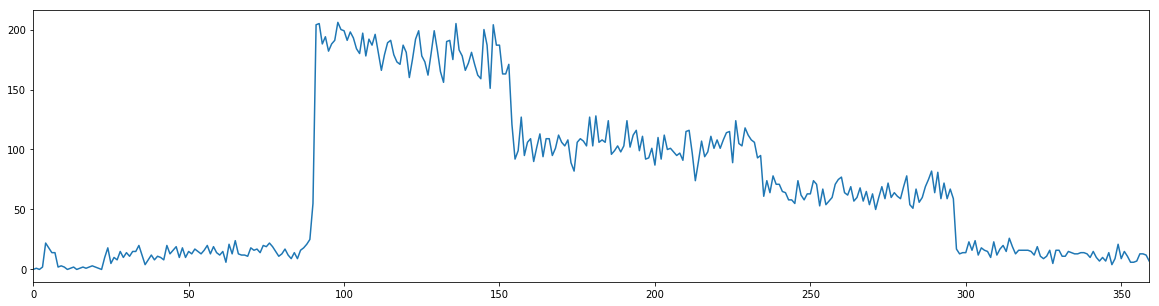

In [4]:
rc = df.loc[df[0]=='$CANDY']
rc.reset_index(drop=True, inplace=True)

rc = rc.apply(pd.to_numeric, errors='coerce')

#rc.to_csv('ble.txt')

#rc['sum'] = rc[range(24,544)].sum(axis=1)
rc['sum'] = rc[range(23,544)].sum(axis=1)
#rc['sum']

plt.figure(figsize=(20,5))

rc['sum'].plot()
#plt.ylim([0,20])

## Energy spectrum

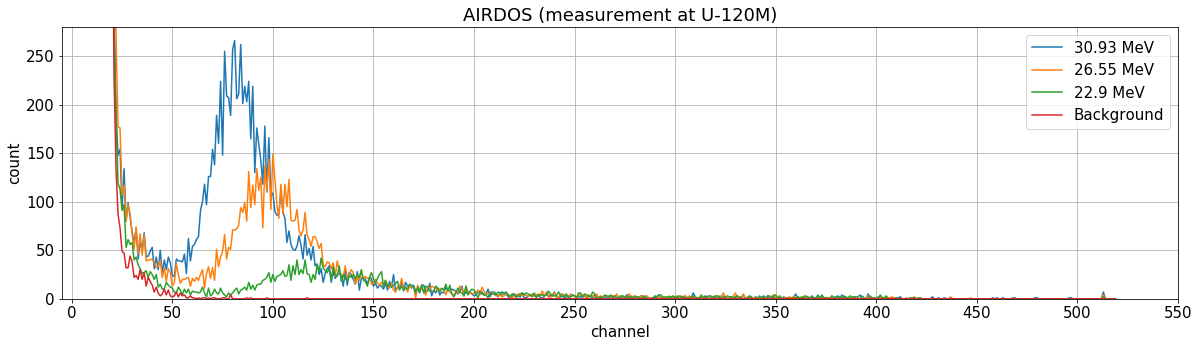

In [10]:
matplotlib.rcParams.update({'font.size': 15})

'''
plt.figure(figsize=(20,5))
rc['sum'][91:154].plot(c='blue')
rc['sum'][155:235].plot(c='red')
rc['sum'][236:296].plot(c='green')
rc['sum'][300:350].plot(c='yellow')
'''

ener1 = rc.ix[91:154,20:520].sum()
ener2 = rc.ix[155:235,20:520].sum()
ener3 = rc.ix[236:296,20:520].sum()
ener4 = rc.ix[300:350,20:520].sum()
 
plt.figure(figsize=(20,5))
plt.plot(ener1, label='30.93 MeV')
plt.plot(ener2, label='26.55 MeV')
plt.plot(ener3, label='22.9 MeV')
plt.plot(ener4, label='Background')
plt.ylim([0,280])
plt.legend()
plt.title('AIRDOS (measurement at U-120M)')
plt.xlabel('channel')
plt.ylabel('count')
plt.xticks(range(0,600,50))
plt.grid()

## Plot Altitude

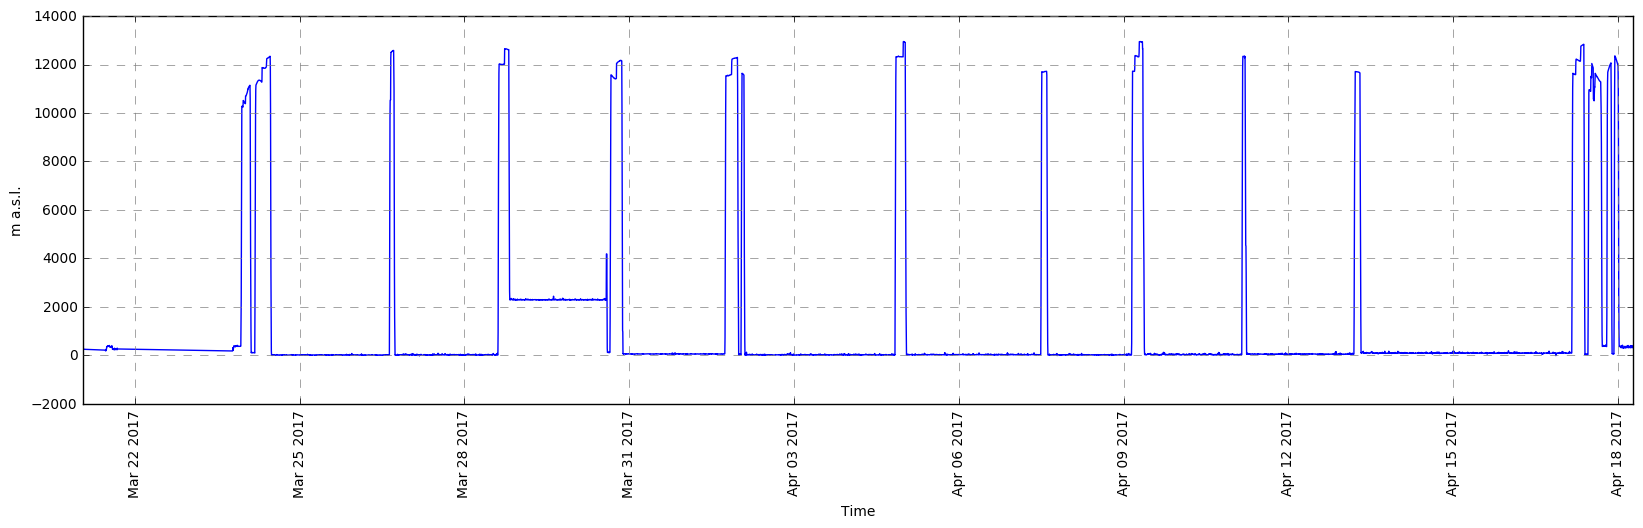

In [5]:
plt.figure(figsize=(20,5))

#df6.set_index('time').altitude.plot()
plt.plot(df6.index, df6.altitude)

plt.xticks(rotation='vertical')
#plt.gcf().autofmt_xdate()
#df5[:17000].plot(x=2,y='avgsnr',figsize=(12,5),xticks=['09:30:00','10:00:00','10:30:00','11:00:00','11:30:00','12:00:00','12:30:00','13:00:00','13:30:00','14:00:00'])
plt.grid(b=True, which='major', color='grey', linestyle='--')
plt.grid(b=True, which='minor', color='grey', linestyle='-')
plt.xlabel('Time')
plt.ylabel('m a.s.l.')

## Convert Grades/Minutes to Grades

In [84]:
df6['Lat'] = df6['Lat'].astype(float)
df6['Lon'] = df6['Lon'].astype(float)

df6['Lats'] = df6['Lats'].str.replace('N','1')
df6['Lats'] = df6['Lats'].str.replace('S','-1')
df6['Lons'] = df6['Lons'].str.replace('E','1')
df6['Lons'] = df6['Lons'].str.replace('W','-1')

df6['LatDD'] = (df6.Lat/100).fillna(0).astype(int)
df6['LatDD'] = df6.LatDD + (df6.Lat - 100.0*df6.LatDD)/60.0
df6['LatDD'] = df6.LatDD * df6['Lats'].astype(float)  


df6['LonDD'] = (df6.Lon/100).fillna(0).astype(int)
df6['LonDD'] = df6.LonDD + (df6.Lon - 100.0*df6.LonDD)/60.0
df6['LonDD'] = df6.LonDD * df6['Lons'].astype(float)  

## Plot Map

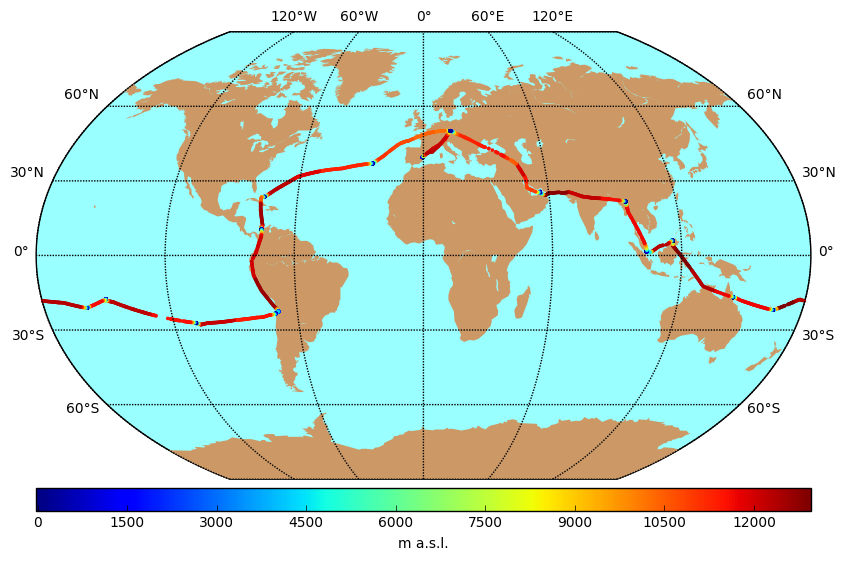

In [12]:
import time, calendar, datetime, numpy
from mpl_toolkits.basemap import Basemap
import matplotlib.pyplot as plt
import urllib, os

plt.figure(figsize=(10,10))

# draw map with markers for float locations
m = Basemap(projection='kav7',lon_0=0)
# create Basemap instance.
#m = Basemap(llcrnrlon=-180,llcrnrlat=-80,urcrnrlon=180,urcrnrlat=85,projection='mill')

x, y = m(df6.LonDD.tolist(),df6.LatDD.tolist())
m.drawmapboundary(fill_color='#99ffff')
m.fillcontinents(color='#cc9966',lake_color='#99ffff',zorder=0)
# draw parallels and meridians, but don't bother labelling them.
m.drawparallels(np.arange(-90.,99.,30.),labels=[1,1,0,0])
m.drawmeridians(np.arange(-180.,180.,60.),labels=[0,0,1,0])
#m.scatter(df6.LonDD.tolist(),df6.LatDD.tolist(),3,marker='o',color='r')
im1 = m.scatter(x,y,c=df6.altitude.tolist(),s=7,marker='o',  linewidth='0', cmap='jet')
cb = m.colorbar(im1,"bottom", size="5%", pad="2%")
cb.set_label('m a.s.l.')
plt.show()

## Plot Flux

In [7]:

date = np.nan #pd.to_datetime('210317000000.00', format='%d%m%y%H%M%S.%f')
altitude = np.nan
LatDD = np.nan
LonDD = np.nan
for i,r in df.iterrows():
    if (r[0] == '$GPRMC'):
        date = pd.to_datetime(str(r[9])+str(r[1]), format='%d%m%y%H%M%S.%f',errors='coerce')
    '''
        Lat = float(r[3])
        Lon = float(r[5])

        if (r[4] == 'N'):
            Lats = 1
        else:
            Lats = -1

        if (r[6] == 'E'):
            Lons = 1
        else:
            Lons = -1

        LatDD = int(Lat/100)
        LatDD = LatDD + (Lat - 100.0*LatDD)/60.0
        LatDD = LatDD * Lats  

        LonDD = int(Lon/100)
        LonDD = LonDD + (Lon - 100.0*LonDD)/60.0
        LonDD = LonDD * Lons  
    '''       
    if (r[0] == '$GPGGA'):
        altitude = r[9]
    #r[20] = date
    df.set_value(i,20,date)
    df.set_value(i,21,altitude)
    #df.set_value(i,22,LatDD)
    #df.set_value(i,23,LonDD)

#df.to_csv('complete.csv')

In [59]:
#dfo = df[[25,26,27]].reset_index().groupby(20).sum()
#df.reset_index(inplace=True)
dfo = df
#dfo.reset_index(inplace=True)
dfo.drop(dfo[dfo[0]=='$GPRMC'].index, inplace=True)
dfo.drop(dfo[dfo[0]=='$GPGGA'].index, inplace=True)

dfo = dfo[range(20,544)].groupby(20).sum()
#dfo

#df.iloc[20:40,0:30]
dfo['sum'] = dfo[range(27,544)].sum(axis=1)

dfo.to_csv('radiation.csv')

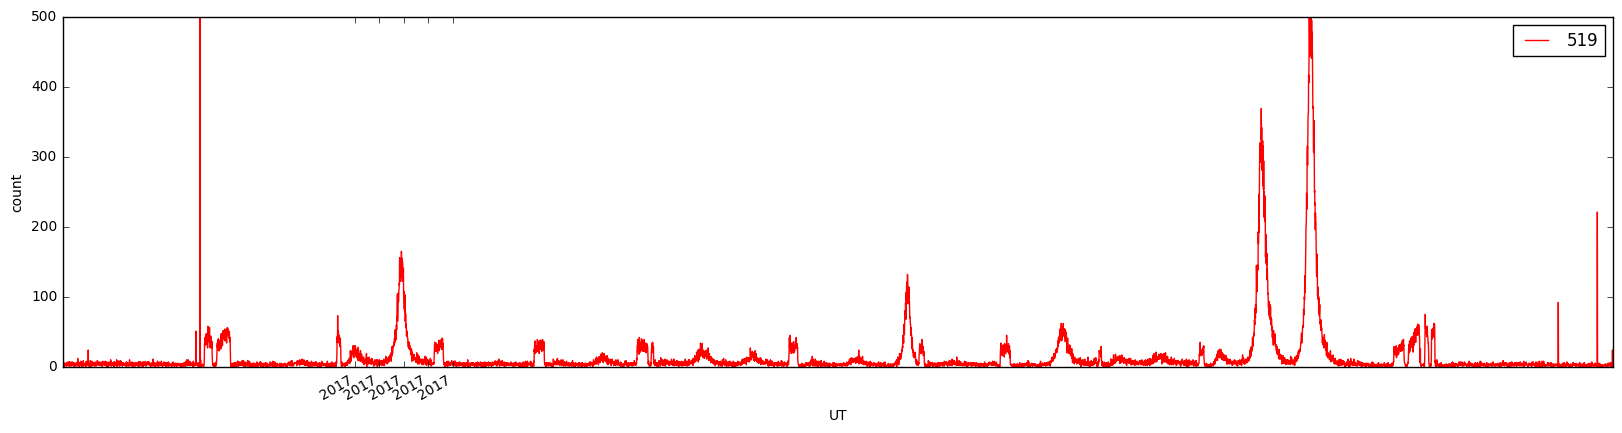

In [66]:
dfo = pd.read_table('radiation.csv', sep=',', header=None)

#plt.figure(figsize=(10,5))

dfo[0] = pd.to_datetime(dfo[0])

dfo = dfo.set_index([0])

#xx = dfo.loc['2017-03-26 00:00:00':'2017-03-30 00:00:00']
xx = dfo

xx.plot(y=519, c='r', xticks=['2017-03-27 00:00','2017-03-27 12:00','2017-03-28 00:00','2017-03-28 12:00','2017-03-29 00:00'],figsize=(20,5))
#plt.plot(dfo[0], dfo[519], c='r')

#plt.xticks(rotation='vertical')
#plt.gcf().autofmt_xdate()
plt.ylim([0,500])
plt.ylabel('count')
plt.xlabel('UT')

## Calculate Flux

In [10]:
rc = df.loc[df[0]=='$CANDY']
rc.reset_index(drop=True, inplace=True)

rc = rc.apply(pd.to_numeric, errors='coerce')

#rc.to_csv('ble.txt')

#rc['sum'] = rc[range(24,544)].sum(axis=1)
rc['sum'] = rc[range(25,544)].sum(axis=1)
#rc['sum']

In [33]:
#df.iloc[20:40,0:30]
#df = df.set_index([20])
xx = df.loc['2017-03-28 14:26:39':'2017-03-28 20:26:42',0:24]

xx.loc[xx[0]=='$GPRMC']

,0,1,2,3,4,5,6,7,8,9,...,14,15,16,17,18,19,21,22,23,24
20,,,,,,,,,,,,,,,,,,,,,
2017-03-28 14:27:44,$GPRMC,142744.00,A,1026.78767,N,07530.93372,W,0.103,NaN,280317,...,NaN,NaN,NaN,NaN,NaN,NaN,14.4,NaN,NaN,NaN
2017-03-28 14:27:45,$GPRMC,142745.00,A,1026.78749,N,07530.93385,W,0.049,NaN,280317,...,NaN,NaN,NaN,NaN,NaN,NaN,14.8,NaN,NaN,NaN
2017-03-28 14:33:06,$GPRMC,143306.00,A,1026.73337,N,07530.83158,W,2.246,95.85,280317,...,NaN,NaN,NaN,NaN,NaN,NaN,8.0,NaN,NaN,NaN
2017-03-28 14:33:07,$GPRMC,143307.00,A,1026.73333,N,07530.83094,W,2.075,95.32,280317,...,NaN,NaN,NaN,NaN,NaN,NaN,8.2,NaN,NaN,NaN
2017-03-28 14:38:27,$GPRMC,143827.00,A,1026.70256,N,07530.76773,W,10.526,169.68,280317,...,NaN,NaN,NaN,NaN,NaN,NaN,51,NaN,NaN,NaN
2017-03-28 14:38:28,$GPRMC,143828.00,A,1026.69954,N,07530.76756,W,10.679,174.86,280317,...,NaN,NaN,NaN,NaN,NaN,NaN,10.5,NaN,NaN,NaN
2017-03-28 14:43:50,$GPRMC,144350.00,A,1032.66281,N,07530.79821,W,264.103,338.80,280317,...,NaN,NaN,NaN,NaN,NaN,NaN,911.4,NaN,NaN,NaN
2017-03-28 14:43:51,$GPRMC,144351.00,A,1032.73128,N,07530.82607,W,265.043,337.39,280317,...,NaN,NaN,NaN,NaN,NaN,NaN,923.8,NaN,NaN,NaN
2017-03-28 14:49:11,$GPRMC,144911.00,A,1012.47784,N,07530.48631,W,384.672,171.66,280317,...,NaN,NaN,NaN,NaN,NaN,NaN,936.7,NaN,NaN,NaN
